In [31]:
# Importação das bibliotecas necessárias
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [32]:
# Definir o caminho para o conjunto de dados
train_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
valid_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
test_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

In [33]:
# Definir hiperparâmetros do modelo
IMAGE_SIZE = [150, 150]
BATCH_SIZE = 32
EPOCHS = 30

In [34]:
# Criar gerador de imagens de treinamento com aumentação de dados
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Criar gerador de imagens de validação sem aumentação de dados
valid_datagen = ImageDataGenerator(rescale = 1./255)

In [35]:
# Preprocessar imagens de treinamento
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size = IMAGE_SIZE,
                                              batch_size = BATCH_SIZE,
                                              class_mode = 'binary')

# Preprocessar imagens de validação
valid_set = valid_datagen.flow_from_directory(valid_path,
                                              target_size = IMAGE_SIZE,
                                              batch_size = BATCH_SIZE,
                                              class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [37]:
# Adicionar camada de entrada
input_layer = Input(shape=IMAGE_SIZE + [3])

In [38]:
# Construir o modelo Inception-V3
inception = hub.KerasLayer('https://kaggle.com/models/google/inception-v3/frameworks/TensorFlow2/variations/classification/versions/2',
                           trainable = False)

In [39]:
# Conectar a camada de entrada à camada do TensorFlow Hub
output_layer = inception(input_layer)

# Adicionar camadas personalizadas ao modelo
x = Flatten()(output_layer)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation = 'sigmoid')(x)

In [40]:
# Definir o modelo final
model = Model(inputs = input_layer, outputs = x)

# Compilar o modelo
model.compile(optimizer = Adam(lr = 0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [41]:
# Treinar o modelo
history = model.fit(train_set,
                    validation_data = valid_set,
                    epochs = EPOCHS)

Epoch 1/30
163/163 [==============================] - 215s 1s/step - loss: 0.4492 - accuracy: 0.8771 - val_loss: 1.1072 - val_accuracy: 0.6875
Epoch 2/30
163/163 [==============================] - 177s 1s/step - loss: 0.2337 - accuracy: 0.9064 - val_loss: 0.5929 - val_accuracy: 0.7500
Epoch 3/30
163/163 [==============================] - 176s 1s/step - loss: 0.2171 - accuracy: 0.9135 - val_loss: 0.8520 - val_accuracy: 0.6875
Epoch 4/30
163/163 [==============================] - 175s 1s/step - loss: 0.2008 - accuracy: 0.9210 - val_loss: 0.7402 - val_accuracy: 0.7500
Epoch 5/30
163/163 [==============================] - 176s 1s/step - loss: 0.1987 - accuracy: 0.9206 - val_loss: 0.8044 - val_accuracy: 0.8125
Epoch 6/30
163/163 [==============================] - 175s 1s/step - loss: 0.1933 - accuracy: 0.9229 - val_loss: 0.9287 - val_accuracy: 0.7500
Epoch 7/30
163/163 [==============================] - 176s 1s/step - loss: 0.1986 - accuracy: 0.9199 - val_loss: 0.8804 - val_accuracy: 0.6875

20/20 [==============================] - 17s 816ms/step


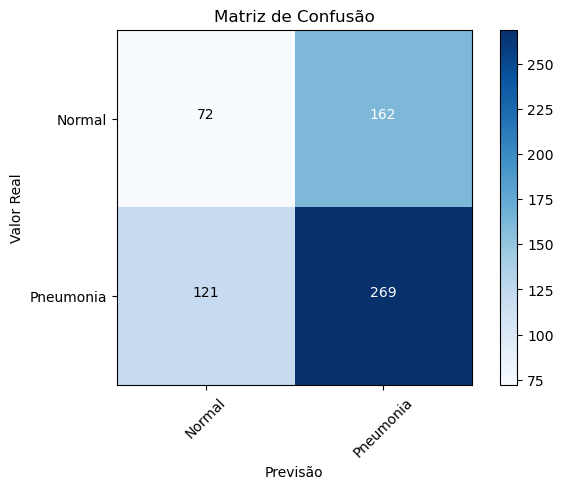

In [51]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

# Criar a matriz de confusão
test_preds = model.predict(test_set)
test_preds = (test_preds > 0.5)
cm = confusion_matrix(test_set.classes, test_preds)

# Plotar a matriz de confusão
classes = ['Normal', 'Pneumonia']
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.xlabel('Previsão')
plt.ylabel('Valor Real')
plt.show()


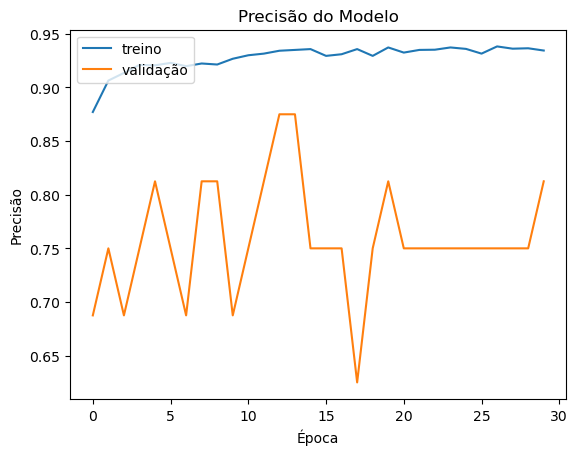

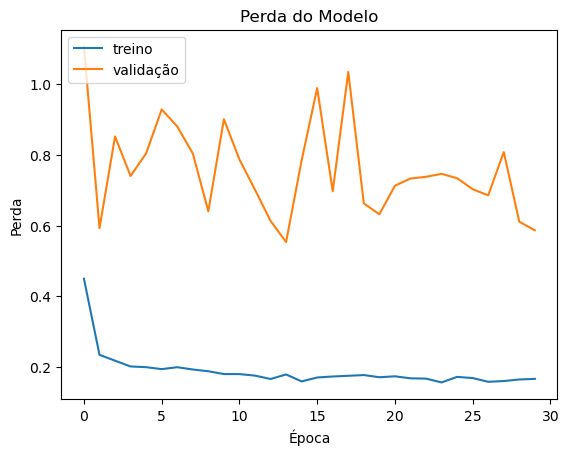

In [52]:
# Plotar a precisão e a perda do modelo
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisão do Modelo')
plt.ylabel('Precisão')
plt.xlabel('Época')
plt.legend(['treino', 'validação'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perda do Modelo')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['treino', 'validação'], loc='upper left')
plt.show()

In [43]:
# Avaliar o modelo no conjunto de testes
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(test_path,
target_size = IMAGE_SIZE,
batch_size = BATCH_SIZE,
class_mode = 'binary')
test_loss, test_acc = model.evaluate(test_set)
print('Test accuracy:', test_acc)

Found 624 images belonging to 2 classes.
20/20 [==============================] - 19s 928ms/step - loss: 0.3713 - accuracy: 0.8702
Test accuracy: 0.870192289352417


In [45]:
#Fazer previsões com o modelo
pred_set = valid_datagen.flow_from_directory(valid_path,
target_size = IMAGE_SIZE,
batch_size = BATCH_SIZE,
class_mode = 'binary')
preds = model.predict(pred_set)

Found 16 images belonging to 2 classes.
1/1 [==============================] - 1s 599ms/step


In [53]:
# salvar o modelo treinado em um arquivo h5
model.save('modelo_Inception_V3.h5')